In [ ]:
#import packages

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import sys
import pandas as pd
import re
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from scipy import stats

#Importing models from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Importing the sequence data of DNA wrappings**

In [ ]:
!gdown 15p34lthi5ma_mOZJFDW8fHFS5Lm6RGEF


Downloading...
From: https://drive.google.com/uc?id=15p34lthi5ma_mOZJFDW8fHFS5Lm6RGEF
To: /content/H3K79me3.txt
100% 15.1M/15.1M [00:00<00:00, 60.2MB/s]


In [ ]:
seqs = []
labels = []

f = open('H3K79me3.txt')
for i, line in enumerate(f):
    if i % 3 == 1:
        line = re.sub('[^ATCGatcg]', '', line)
        seqs.append(line)
    if i%3 == 2:
        labels.append(int(line[0]))
f.close()

# **Data Exploration and Visualization**

In [ ]:
data = []
for i,j in zip(seqs,labels):
  data.append([i,len(i),j])


In [ ]:
df = pd.DataFrame (data, columns = ['Sequence','length', 'Class'])
df.head(5)

,Sequence,length,Class
0,CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...,310,1
1,CATGTAGTATTGGGCTAAGTGAGCTCTGATATCAGAGACGTAGACA...,500,0
2,CTGAATTCAGTCTGCTTTAAACGGCTTCCGCGGAGGAAATATTTCC...,500,0
3,TAGCCGCTGAGAAGCGGATGGTAATGAGACAAGTTGATATCAAACA...,500,0
4,AGGGAAACAGTAAACAGTGAAAATTCTCTTGAGAACCAAAGTAAAC...,500,0


In [ ]:
print("Maximum length of nucleotides in a sequence :",df.length.max())
print("Average length of nucleotides in a sequence :",df.length.mean().round())
print("Minimum length of nucleotides in a sequence :",df.length.min())

Maximum length of nucleotides in a sequence : 500
Average length of nucleotides in a sequence : 500.0
Minimum length of nucleotides in a sequence : 290


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


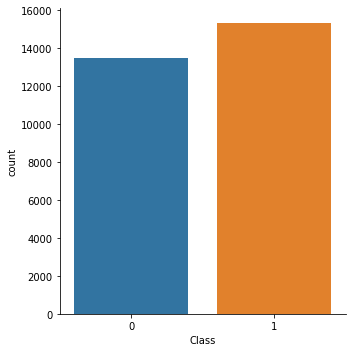

In [ ]:
sns.factorplot('Class',data=df,kind='count')

In [ ]:
print("Samples with no DNA wrapping around histone protein :",df[df.Class == 0].shape[0])
print("Samples with DNA wrapping around histone protein :",df[df.Class == 1].shape[0])

Samples with no DNA wrapping around histone protein : 13500
Samples with DNA wrapping around histone protein : 15337


# **K-mer based Classification**

In [ ]:
def Kmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

kmer_seq=[]
for seq in seqs:
    kmer_seq.append(Kmers(seq))
    


In [ ]:
print(kmer_seq[0])

['cacacc', 'acacca', 'caccac', 'accaca', 'ccacac', 'cacacc', 'acaccc', 'caccca', 'acccac', 'cccaca', 'ccacac', 'cacaca', 'acacac', 'cacacc', 'acaccc', 'caccca', 'acccac', 'cccaca', 'ccacac', 'cacaca', 'acacac', 'cacacc', 'acacca', 'caccac', 'accaca', 'ccacac', 'cacacc', 'acacca', 'caccac', 'accaca', 'ccacac', 'cacaca', 'acacac', 'cacacc', 'acacca', 'caccac', 'accaca', 'ccacac', 'cacacc', 'acacca', 'caccac', 'accaca', 'ccacac', 'cacacc', 'acaccc', 'caccca', 'acccac', 'cccaca', 'ccacac', 'cacaca', 'acacac', 'cacaca', 'acacac', 'cacaca', 'acacac', 'cacaca', 'acacat', 'cacatc', 'acatcc', 'catcct', 'atccta', 'tcctaa', 'cctaac', 'ctaaca', 'taacac', 'aacact', 'acacta', 'cactac', 'actacc', 'ctaccc', 'taccct', 'acccta', 'ccctaa', 'cctaac', 'ctaaca', 'taacac', 'aacaca', 'acacag', 'cacagc', 'acagcc', 'cagccc', 'agccct', 'gcccta', 'ccctaa', 'cctaat', 'ctaatc', 'taatct', 'aatcta', 'atctaa', 'tctaac', 'ctaacc', 'taaccc', 'aaccct', 'accctg', 'ccctgg', 'cctggc', 'ctggcc', 'tggcca', 'ggccaa', 'gccaac',

In [ ]:
for item in range(len(kmer_seq)):
    kmer_seq[item] = ' '.join(kmer_seq[item])

In [ ]:
print(kmer_seq[0])

cacacc acacca caccac accaca ccacac cacacc acaccc caccca acccac cccaca ccacac cacaca acacac cacacc acaccc caccca acccac cccaca ccacac cacaca acacac cacacc acacca caccac accaca ccacac cacacc acacca caccac accaca ccacac cacaca acacac cacacc acacca caccac accaca ccacac cacacc acacca caccac accaca ccacac cacacc acaccc caccca acccac cccaca ccacac cacaca acacac cacaca acacac cacaca acacac cacaca acacat cacatc acatcc catcct atccta tcctaa cctaac ctaaca taacac aacact acacta cactac actacc ctaccc taccct acccta ccctaa cctaac ctaaca taacac aacaca acacag cacagc acagcc cagccc agccct gcccta ccctaa cctaat ctaatc taatct aatcta atctaa tctaac ctaacc taaccc aaccct accctg ccctgg cctggc ctggcc tggcca ggccaa gccaac ccaacc caacct aacctg acctgt cctgtc ctgtct tgtctc gtctct tctctc ctctca tctcaa ctcaac tcaact caactt aactta acttac cttacc ttaccc taccct accctc ccctcc cctcca ctccat tccatt ccatta cattac attacc ttaccc taccct accctg ccctgc cctgcc ctgcct tgcctc gcctcc cctcca ctccac tccact ccactc cactcg actcgt ctcgtt tcgtta

In [ ]:
cv = CountVectorizer(ngram_range=(4,4))
Kmer_verctorized = cv.fit_transform(kmer_seq)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(Kmer_verctorized , labels, test_size=0.1, random_state=42)

In [ ]:
# Models to train
names = ['K Nearest Neighbors', 'Decision Tree', 'Random Forest', 'AddaBoost']
Classifiers = [
    KNeighborsClassifier(n_neighbors = 3),
    DecisionTreeClassifier(max_depth = 5),
    RandomForestClassifier(max_depth = 5, n_estimators = 10, max_features = 1 ),
    AdaBoostClassifier(),    
    ]
    
models = zip(names, Classifiers)
# import KFold
from sklearn.model_selection import KFold, cross_val_score

names = []
result = []
for name, model in models:
    kfold = KFold(n_splits = 10)
    cv_results = cross_val_score(model, train_x, train_y, cv = kfold, scoring = 'accuracy')
    result.append(cv_results)
    names.append(name)
    msg = "{0}: {1} ({2})".format(name, cv_results.mean(), cv_results.std())
    print(msg)

K Nearest Neighbors: 0.6701324848366095 (0.0436227169195937)
Decision Tree: 0.6548372626035015 (0.008104347588762564)
Random Forest: 0.5349283023237172 (0.007326781108473265)
AddaBoost: 0.7068543869180687 (0.007266520808956555)


In [ ]:
names = ['K Nearest Neighbors', 'Decision Tree', 'Random Forest', 'AddaBoost']
Classifiers = [
    KNeighborsClassifier(n_neighbors = 3),
    DecisionTreeClassifier(max_depth = 5),
    RandomForestClassifier(max_depth = 5, n_estimators = 10, max_features = 1 ),
    AdaBoostClassifier(),    
    ]

models = zip(names, Classifiers)

for name, model in models:
    model.fit(train_x, train_y)
    preds = model.predict(test_x)
    print(name)
    print(accuracy_score(test_y, preds))
    print(classification_report(test_y, preds))

K Nearest Neighbors
0.6719833564493759
              precision    recall  f1-score   support

           0       0.60      0.91      0.73      1379
           1       0.84      0.46      0.59      1505

    accuracy                           0.67      2884
   macro avg       0.72      0.68      0.66      2884
weighted avg       0.73      0.67      0.66      2884

Decision Tree
0.6560332871012483
              precision    recall  f1-score   support

           0       0.78      0.40      0.52      1379
           1       0.62      0.90      0.73      1505

    accuracy                           0.66      2884
   macro avg       0.70      0.65      0.63      2884
weighted avg       0.69      0.66      0.63      2884

Random Forest
0.5232316227461858
              precision    recall  f1-score   support

           0       0.64      0.01      0.01      1379
           1       0.52      1.00      0.69      1505

    accuracy                           0.52      2884
   macro avg       0.58

# **Onehote Encoding Classification**

In [ ]:
def onehote(sequence):
    mapping = {"A": 0, "C": 1, "G": 2, "T": 3}
    seq2 = [mapping[i] for i in sequence]
    return np.eye(4)[seq2]

encodedDNA=[]
for seq in seqs:
    encodedDNA.append(onehote(seq))
    
paddedSeq=tf.keras.preprocessing.sequence.pad_sequences(encodedDNA)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(
    paddedSeq, labels, test_size=0.1, random_state=42)

In [ ]:
def data_loader(train_x, val_x, train_y, val_y,
                batch_size=50):

    train_x, val_x, train_y, val_y =\
    tuple(torch.tensor(data) for data in
          [train_x, val_x, train_y, val_y])

    train_data = TensorDataset(train_x, train_y)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    val_data = TensorDataset(val_x, val_y)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [ ]:
train_dataloader, test_dataloader = data_loader(torch.permute(torch.tensor(train_x),(0,2,1)), torch.permute(torch.tensor(test_x),(0,2,1)), train_y, test_y, batch_size=50)

<ipython-input-16-60ad578f0999>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tuple(torch.tensor(data) for data in


In [ ]:
class OnehotCNN(nn.Module):
    def __init__(self, ):
        super(OnehotCNN, self).__init__()

        self.Conv1 = nn.Conv1d(in_channels=4, out_channels=320, kernel_size=6)
        self.Conv2 = nn.Conv1d(in_channels=320, out_channels=320, kernel_size=6)
        self.Maxpool1 = nn.MaxPool1d(kernel_size=3, stride=3)
        self.Drop1 = nn.Dropout(p=0.2)
        
        self.Conv3 = nn.Conv1d(in_channels=320, out_channels=480, kernel_size=6)
        self.Conv4 = nn.Conv1d(in_channels=480, out_channels=480, kernel_size=6)
        self.Maxpool2 = nn.MaxPool1d(kernel_size=3, stride=3)
        self.Drop2 = nn.Dropout(p=0.2)

        self.Conv5 = nn.Conv1d(in_channels=480, out_channels=960, kernel_size=6)
        self.Conv6 = nn.Conv1d(in_channels=960, out_channels=960, kernel_size=6)
        self.Drop3 = nn.Dropout(p=0.2)


        
        self.convs = nn.Sequential(self.Conv1,self.Conv2,self.Maxpool1,self.Drop1,
                                    self.Conv3,self.Conv4,self.Maxpool2,self.Drop2,
                                   self.Conv5, self.Conv6, self.Drop3,                 
                                    )
        
        self.Linear1 = nn.Linear(960*41, 2004)
        self.Linear2 = nn.Linear(2004, 2)
        

    def forward(self, input):
        x = self.convs(input)
        x = x.view(-1, 960*41)
        x = self.Linear1(x)

        x = F.relu(x)
        x = self.Linear2(x)

        return x

In [ ]:
def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='same')

def accuracy(net, dataloader):

    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            input, labels = batch
            input, labels = input.to(device), labels.to(device)
            outputs = net(input.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total


def eval(net, train_dataloader, test_dataloader):


    train_acc = accuracy(net, train_dataloader)
    test_acc = accuracy(net, test_dataloader)
    

    print("Train accuracy: " + str(accuracy(net, train_dataloader)))
    print("Test accuracy: " + str(accuracy(net, test_dataloader)))
          
    return train_acc, test_acc

def plot_losses(losses, smooth_val = None, title = ""):

    epochs = [i for i in range(1, len(losses) + 1)]
    if smooth_val is not None:
        lossses = smooth(losses, smooth_val)
    plt.plot(epochs, losses, marker="o", linestyle="dashed")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    
def plot_acc(acc, smooth_val = None, title = ""):
 
    epochs = [i for i in range(1, len(acc) + 1)]
    if smooth_val is not None:
        acc = smooth(acc, smooth_val)
    plt.plot(epochs, acc, marker="o", linestyle="dashed")
    plt.xlabel("Epoch")
    plt.ylabel("Acc")
    plt.title(title)

In [ ]:
def train(net, dataloader, epochs=50, lr=0.001, momentum=0.9, decay=0.005, verbose=1):

  net.to(device)
  losses_per_epoch = []
  acc_per_epoch = []
  test_per_epoch = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    correct = 0
    total= 0
    losses = []
    for i, batch in enumerate(dataloader, 0):
        # get the inputs and labels
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward 
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
         # backward 
        loss.backward()
         # optimize 
        optimizer.step()

        # print 
        losses.append(loss.item())
        sum_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
    
    losses_per_epoch.append(np.mean(losses))
    
    acc_per_epoch.append(100 * correct / total) 

    # calculate acc on the test set 
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for batch in test_dataloader:
            input, labels = batch
            input, labels = input.to(device), labels.to(device)
            outputs = net(input.float())
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
    test_per_epoch.append(100 * correct_test / total_test)
    
  return losses_per_epoch, acc_per_epoch, test_per_epoch

In [ ]:
net = OnehotCNN()

In [ ]:
Onehot_losses,Onehot_acc,Onehot_test_acc = train(net,train_dataloader,epochs=50 )

[1,   100] loss: 0.692
[1,   200] loss: 0.689
[1,   300] loss: 0.689
[1,   400] loss: 0.687
[1,   500] loss: 0.681
[2,   100] loss: 0.662
[2,   200] loss: 0.610
[2,   300] loss: 0.593
[2,   400] loss: 0.589
[2,   500] loss: 0.592
[3,   100] loss: 0.567
[3,   200] loss: 0.548
[3,   300] loss: 0.565
[3,   400] loss: 0.545
[3,   500] loss: 0.566
[4,   100] loss: 0.533
[4,   200] loss: 0.531
[4,   300] loss: 0.541
[4,   400] loss: 0.531
[4,   500] loss: 0.533
[5,   100] loss: 0.526
[5,   200] loss: 0.510
[5,   300] loss: 0.532
[5,   400] loss: 0.517
[5,   500] loss: 0.508
[6,   100] loss: 0.509
[6,   200] loss: 0.509
[6,   300] loss: 0.503
[6,   400] loss: 0.493
[6,   500] loss: 0.511
[7,   100] loss: 0.498
[7,   200] loss: 0.498
[7,   300] loss: 0.477
[7,   400] loss: 0.488
[7,   500] loss: 0.485
[8,   100] loss: 0.489
[8,   200] loss: 0.488
[8,   300] loss: 0.475
[8,   400] loss: 0.475
[8,   500] loss: 0.485
[9,   100] loss: 0.469
[9,   200] loss: 0.476
[9,   300] loss: 0.491
[9,   400] 

In [ ]:
eval(net, train_dataloader, test_dataloader)

Train accuracy: 0.809347666936385
Test accuracy: 0.7985436893203883


(0.8089623550263939, 0.79750346740638)

In [ ]:
with open("acc_test.txt", "w") as output:
    output.write(str(Onehot_test_acc))

In [ ]:
torch.save(net.state_dict(), 'OneHotCNN.pth')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp OneHotCNN.pth /content/drive/MyDrive

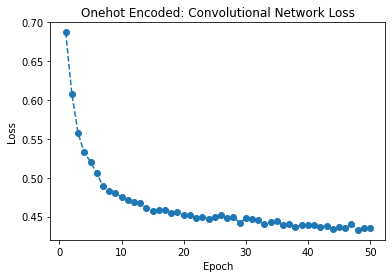

In [ ]:
plot_losses(Onehot_losses, title = "Onehot Encoded: Convolutional Network Loss")

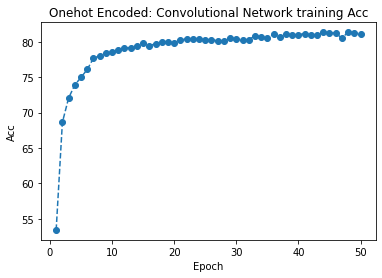

In [ ]:
plot_acc(Onehot_acc, title = "Onehot Encoded: Convolutional Network training Acc")

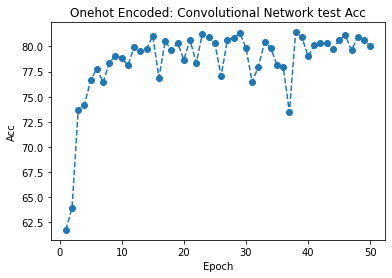

In [ ]:
plot_acc(Onehot_test_acc, title = "Onehot Encoded: Convolutional Network test Acc")

# **Sequence to Vector Classification**

In [ ]:
def tokenize_seq(seqs):

    max_len = 0
    vocab_size = {j:i for i,j in enumerate(['<pad>', '<unk>', 'A', 'T', 'C', 'G'])}
    i = len(vocab_size)

    tokenized_seqs = []
    for seq in seqs:
        tokenized_seq = []
        for e in seq:
            seq = seq.upper()
            if not e in vocab_size:
                vocab_size[e] = i
                i += 1
            tokenized_seq.append(vocab_size[e])
        tokenized_seqs.append(tokenized_seq)
        
    return tokenized_seqs, vocab_size
        

def pad(tokenized_seqs, vocab_size):


    padded_seqs = []
    
    max_len = 0
    for seq in tokenized_seqs:
        max_len = max(len(seq), max_len)
    
    for seq in tokenized_seqs:
        padded_seq = seq + [vocab_size['<pad>']] * (max_len - len(seq))
        padded_seqs.append(padded_seq)
        
    return np.array(padded_seqs, dtype=np.float32)


In [ ]:
tokenized_seqs, vocab_size = tokenize_seq(seqs)

tokenized_seqs = pad(tokenized_seqs, vocab_size)



train_x, test_x, train_y, test_y = train_test_split(
    tokenized_seqs, labels, test_size=0.1, random_state=42)

train_dataloader, test_dataloader = data_loader(train_x, test_x, train_y, test_y, batch_size=50)

In [ ]:
def train(net, dataloader, epochs=50, lr=0.001, momentum=0.9, decay=0.005, verbose=1):

  net.to(device)
  losses_per_epoch = []
  acc_per_epoch = []
  test_per_epoch = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    correct = 0
    total= 0
    losses = []
    for i, batch in enumerate(dataloader, 0):
        # get the inputs and labels
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
         # backward 
        loss.backward()
         # optimize 
        optimizer.step()

        # print 
        losses.append(loss.item())
        sum_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
    
    losses_per_epoch.append(np.mean(losses))
    
    acc_per_epoch.append(100 * correct / total) 

    # calculate acc on the test set 
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for batch in test_dataloader:
            input, labels = batch
            input, labels = input.to(device), labels.to(device)
            outputs = net(input)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
    test_per_epoch.append(100 * correct_test / total_test)
    
  return losses_per_epoch, acc_per_epoch, test_per_epoch

In [ ]:
class Embedded_CNN(nn.Module):
    def __init__(self, vocab_size, num_classes=2):


        super(Embedded_CNN, self).__init__()
        self.vocab_size = vocab_size

        self.encoder = nn.Embedding(self.vocab_size, 2)
        

        self.Conv1 = nn.Conv1d(in_channels=2, out_channels=320, kernel_size=6)
        self.Conv2 = nn.Conv1d(in_channels=320, out_channels=320, kernel_size=6)
        self.Maxpool1 = nn.MaxPool1d(kernel_size=3, stride=3)
        self.Drop1 = nn.Dropout(p=0.2)
        
        self.Conv3 = nn.Conv1d(in_channels=320, out_channels=480, kernel_size=6)
        self.Conv4 = nn.Conv1d(in_channels=480, out_channels=480, kernel_size=6)
        self.Maxpool2 = nn.MaxPool1d(kernel_size=3, stride=3)
        self.Drop2 = nn.Dropout(p=0.2)

        self.Conv5 = nn.Conv1d(in_channels=480, out_channels=960, kernel_size=6)
        self.Conv6 = nn.Conv1d(in_channels=960, out_channels=960, kernel_size=6)
        self.Drop3 = nn.Dropout(p=0.2)


        
        self.convs = nn.Sequential(self.Conv1,self.Conv2,self.Maxpool1,self.Drop1,
                                    self.Conv3,self.Conv4,self.Maxpool2,self.Drop2,
                                   self.Conv5, self.Conv6, self.Drop3,                 
                                    )
        
        self.Linear1 = nn.Linear(960*41, 2004)
        self.Linear2 = nn.Linear(2004, 2)



    def forward(self, x):
      
        x = torch.tensor(x).to(torch.int64)

        x = self.encoder(x)

        x = x.permute(0, 2, 1)

        x = self.convs(x)
        
        x = x.view(-1, 960 * 41)

        x = self.Linear1(x)

        x = F.relu(x)
        x = self.Linear2(x)

        return x



In [ ]:
net = Embedded_CNN(len(vocab_size))

In [ ]:
Embedded_loss,Embedded_acc,Embedded_acc_test = train(net,train_dataloader,epochs=50 )

<ipython-input-10-04e89d323c86>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(torch.int64)


[1,   100] loss: 0.691
[1,   200] loss: 0.682
[1,   300] loss: 0.653
[1,   400] loss: 0.638
[1,   500] loss: 0.623
[2,   100] loss: 0.611
[2,   200] loss: 0.595
[2,   300] loss: 0.579
[2,   400] loss: 0.582
[2,   500] loss: 0.586
[3,   100] loss: 0.567
[3,   200] loss: 0.557
[3,   300] loss: 0.552
[3,   400] loss: 0.541
[3,   500] loss: 0.554
[4,   100] loss: 0.540
[4,   200] loss: 0.541
[4,   300] loss: 0.530
[4,   400] loss: 0.533
[4,   500] loss: 0.518
[5,   100] loss: 0.510
[5,   200] loss: 0.515
[5,   300] loss: 0.534
[5,   400] loss: 0.513
[5,   500] loss: 0.514
[6,   100] loss: 0.509
[6,   200] loss: 0.493
[6,   300] loss: 0.515
[6,   400] loss: 0.498
[6,   500] loss: 0.507
[7,   100] loss: 0.495
[7,   200] loss: 0.496
[7,   300] loss: 0.495
[7,   400] loss: 0.492
[7,   500] loss: 0.481
[8,   100] loss: 0.482
[8,   200] loss: 0.492
[8,   300] loss: 0.482
[8,   400] loss: 0.487
[8,   500] loss: 0.488
[9,   100] loss: 0.480
[9,   200] loss: 0.481
[9,   300] loss: 0.461
[9,   400] 

In [ ]:
eval(net, train_dataloader, test_dataloader)

<ipython-input-10-04e89d323c86>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(torch.int64)


Train accuracy: 0.8200978692251377
Test accuracy: 0.8068654646324549


(0.8197510885061458, 0.8040915395284327)

In [ ]:
with open("acc_test_1.txt", "w") as output:
    output.write(str(Embedded_acc_test))

In [ ]:
torch.save(net.state_dict(), 'EmbeddedCNN.pth')

In [ ]:
!cp EmbeddedCNN.pth /content/drive/MyDrive

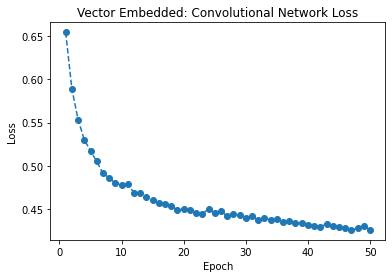

In [ ]:
plot_losses(Embedded_loss, title = "Vector Embedded: Convolutional Network Loss")

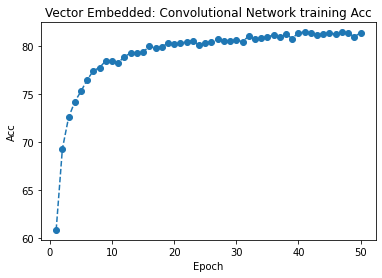

In [ ]:
plot_acc(Embedded_acc, title = "Vector Embedded: Convolutional Network training Acc")

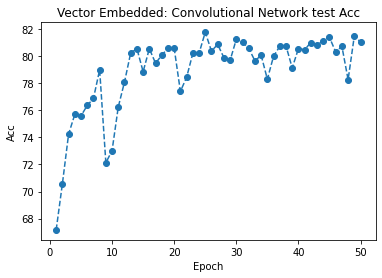

In [ ]:
plot_acc(Embedded_acc_test, title = "Vector Embedded: Convolutional Network test Acc")

# **Model Evaluation**

In [ ]:
acc_onehot = [53.43505567757099, 68.62405116942165, 72.05332716834278, 73.91823681269987, 74.97784456517552, 76.09524910414981, 77.69044041151312, 78.02566177320541, 78.36858937309752, 78.55353908989326, 78.87720109428582, 79.13536007397988, 79.17003814587909, 79.42819712557315, 79.86745270296305, 79.478287673872, 79.72103417716642, 79.93680884676145, 79.9213963703618, 79.89442453666243, 80.24505837475436, 80.42615497245019, 80.40688937695064, 80.36835818595152, 80.27973644665357, 80.28358956575347, 80.15258351635649, 80.09093361075792, 80.53789542634763, 80.41459561515046, 80.22964589835472, 80.26047085115401, 80.88467614533965, 80.66119523754479, 80.49551111624861, 81.08118521943513, 80.65348899934497, 81.09274457673487, 80.9309135745386, 81.00412283743691, 81.173660077833, 80.95403228913806, 80.90394174083922, 81.35090355642893, 81.27769429353062, 81.21604438793203, 80.53789542634763, 81.35475667552885, 81.30851924632991, 81.1351288868339]
acc_embedded = [60.84845682580048, 69.29449389280623, 72.5696451277309, 74.21107386429314, 75.30150656956806, 76.49982660964051, 77.4438407891188, 77.77520903171117, 78.48418294609486, 78.47262358879513, 78.27996763379956, 78.91573228528493, 79.28563171887643, 79.31260355257581, 79.38966593457404, 79.97534003776056, 79.82506839286403, 79.92910260856164, 80.30285516125304, 80.18340846915578, 80.34909259045197, 80.46853928254923, 80.56486726004701, 80.10249296805765, 80.35294570955189, 80.44542056794975, 80.75367009594267, 80.58798597464647, 80.49165799714869, 80.65734211844489, 80.4608330443494, 81.05036026663583, 80.70357954764381, 80.89623550263939, 80.95017917003814, 81.173660077833, 80.91935421723886, 81.24301622163141, 80.79605440604169, 81.41255346202752, 81.45108465302663, 81.41640658112742, 81.16210072053327, 81.30081300813008, 81.32778484182946, 81.25842869803105, 81.4395252957269, 81.37016915192848, 80.98100412283743, 81.39714098562787]

acc_test_onehot = [61.754507628294036, 63.90429958391123, 73.71705963938973, 74.20249653259361, 76.62968099861304, 77.80859916782246, 76.42163661581138, 78.36338418862691, 79.09153952843273, 78.84882108183079, 78.12066574202497, 79.92371705963939, 79.50762829403607, 79.71567267683773, 81.06796116504854, 76.90707350901526, 80.54785020804438, 79.6116504854369, 80.374479889043, 78.6754507628294, 80.65187239944521, 78.36338418862691, 81.2760055478502, 80.89459084604715, 80.30513176144244, 77.04576976421636, 80.61719833564494, 80.85991678224688, 81.31067961165049, 79.8890429958391, 76.45631067961165, 77.98196948682386, 80.40915395284327, 79.85436893203884, 78.15533980582525, 77.98196948682386, 73.47434119278779, 81.41470180305132, 80.96393897364771, 79.02219140083218, 80.09708737864078, 80.30513176144244, 80.30513176144244, 79.71567267683773, 80.65187239944521, 81.10263522884883, 79.6116504854369, 80.96393897364771, 80.65187239944521, 80.02773925104022]
acc_test_embedded = [67.1636615811373, 70.5617198335645, 74.2371705963939, 75.69348127600554, 75.58945908460471, 76.35228848821082, 76.87239944521498, 78.9875173370319, 72.12205270457697, 73.02357836338419, 76.24826629680999, 78.08599167822469, 80.23578363384189, 80.54785020804438, 78.84882108183079, 80.54785020804438, 79.47295423023579, 80.0624133148405, 80.58252427184466, 80.58252427184466, 77.39251040221914, 78.43273231622746, 80.20110957004161, 80.20110957004161, 81.76144244105409, 80.374479889043, 80.85991678224688, 79.8890429958391, 79.68099861303745, 81.24133148404994, 81.03328710124826, 80.58252427184466, 79.64632454923716, 80.0624133148405, 78.29403606102635, 79.99306518723995, 80.72122052704577, 80.75589459084604, 79.12621359223301, 80.54785020804438, 80.47850208044383, 80.998613037448, 80.8252427184466, 81.13730929264909, 81.38002773925103, 80.30513176144244, 80.72122052704577, 78.25936199722608, 81.48404993065188, 81.03328710124826]

loss_onehot = [0.6873024037251105, 0.6077470740446678, 0.5571199778753978, 0.5324605903946437, 0.5203388563142373, 0.5059502457196896, 0.48926444861751334, 0.4829572099619187, 0.48002384405296583, 0.4750557867380289, 0.4706818668888165, 0.46871195022876444, 0.46689890468349826, 0.4607369708613707, 0.45725879170573674, 0.45813510555487413, 0.4586437382377111, 0.45501099208799695, 0.4555033503816678, 0.4525689266335506, 0.4518690114984146, 0.4486955070724854, 0.4493089871910902, 0.44743600327235, 0.4489680969657806, 0.4520635206825458, 0.44748481959104536, 0.4495315184386877, 0.44190136896303067, 0.44774814050358075, 0.44655342276852866, 0.44509059643516174, 0.43983384175942497, 0.4425517735572962, 0.44401221281060804, 0.4386891881720378, 0.4404871491285471, 0.43613415343257095, 0.4387753801850172, 0.4391214199364185, 0.43893316944058125, 0.43657026786643727, 0.4380911586089776, 0.43448344512054554, 0.4362102093604895, 0.43493479513205013, 0.4408075649577838, 0.4327478374999303, 0.43479498750888385, 0.4349940774532465]
loss_embedded = [0.6543279685653173, 0.5889267307634537, 0.5534403923039253, 0.5302756664558099, 0.5172987000873456, 0.5051727527036116, 0.49139343694998666, 0.48633760827092026, 0.47993512422992635, 0.4780702900428038, 0.4794226417747828, 0.46889887886265147, 0.4682097099721432, 0.46369705085570995, 0.46060339971803704, 0.4566627223904316, 0.45617312429329526, 0.45418898047736056, 0.4489270640107302, 0.45046849222137375, 0.44910260301369886, 0.4461327816431339, 0.4443270279237857, 0.45061840168558637, 0.4459440253674984, 0.4477674309737407, 0.4422343981094085, 0.44427293175115035, 0.4431760644683471, 0.4395847891529019, 0.4426350133063702, 0.4374420768652971, 0.43996276780962945, 0.43756171284386747, 0.43818230436971556, 0.435080816080937, 0.43654565507402787, 0.433796501904726, 0.43428307118324133, 0.43159999027848245, 0.43095542086431615, 0.42978163135166353, 0.4329609389775074, 0.430500894641647, 0.42979983816353173, 0.4282493802217337, 0.42611865073155897, 0.4278102836643274, 0.4306806622216335, 0.4264126795129134]


Text(0.5, 1.0, 'Accuracy on the test set')

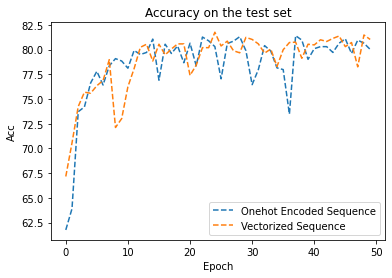

In [ ]:
epochs = range(0,50)
plt.plot(epochs, acc_test_onehot, linestyle="dashed", label="Onehot Encoded Sequence")
plt.plot(epochs, acc_test_embedded, linestyle="dashed", label="Vectorized Sequence")
plt.legend(loc="lower right")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.title("Accuracy on the test set")

Text(0.5, 1.0, 'Training loss')

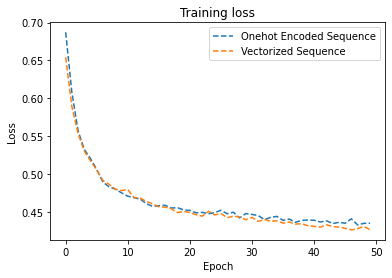

In [ ]:
epochs = range(0,50)
plt.plot(epochs, loss_onehot, linestyle="dashed", label="Onehot Encoded Sequence")
plt.plot(epochs, loss_embedded, linestyle="dashed", label="Vectorized Sequence")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")

In [ ]:
CNN_onehot = OnehotCNN()
CNN_onehot.load_state_dict(torch.load('/content/OneHotCNN.pth', map_location=torch.device('cpu')))

CNN_Embedded = Embedded_CNN(len(vocab_size))
CNN_Embedded.load_state_dict(torch.load('/content/EmbeddedCNN.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:
preds=torch.zeros(0,dtype=torch.long, device='cpu')
targets=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for batch in test_dataloader:
        input, labels = batch
        input, labels = input.to(device), labels.to(device)
        outputs = CNN_Embedded(input)
        _, predicted = torch.max(outputs.data, 1)

        preds=torch.cat([preds,predicted.view(-1).cpu()])
        targets=torch.cat([targets,labels.view(-1).cpu()])

print('CNN - Sequence to  Vector')
print(accuracy_score(targets, preds))
print(classification_report(targets, preds))

<ipython-input-11-04e89d323c86>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(torch.int64)


CNN - Sequence to  Vector
0.8075589459084604
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1379
           1       0.81      0.82      0.82      1505

    accuracy                           0.81      2884
   macro avg       0.81      0.81      0.81      2884
weighted avg       0.81      0.81      0.81      2884



In [ ]:
preds=torch.zeros(0,dtype=torch.long, device='cpu')
targets=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for batch in test_dataloader:
        input, labels = batch
        input, labels = input.to(device), labels.to(device)
        outputs = CNN_onehot(input.float())
        _, predicted = torch.max(outputs.data, 1)

        preds=torch.cat([preds,predicted.view(-1).cpu()])
        targets=torch.cat([targets,labels.view(-1).cpu()])

print('CNN - Onehot Encoded')
print(accuracy_score(targets, preds))
print(classification_report(targets, preds))

CNN - Onehot Encoded
0.8002773925104022
              precision    recall  f1-score   support

           0       0.88      0.67      0.76      1379
           1       0.75      0.92      0.83      1505

    accuracy                           0.80      2884
   macro avg       0.82      0.79      0.80      2884
weighted avg       0.82      0.80      0.80      2884

